In [1]:
%pylab inline
import numpy as np
np.set_printoptions(precision=6, linewidth=110)

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# import scipy.interpolate as interpolate
# import scipy.integrate as integrate
# import scipy.optimize as optimize

import pycbc.filter
import pycbc.types
import pycbc.psd

Populating the interactive namespace from numpy and matplotlib



In [2]:
sys.path.insert(0, '../../src')

import waveform as wave
import waveformset as ws
import surrogate
import diagnostics
import plotparams

import imp
imp.reload(wave)
imp.reload(ws)
imp.reload(surrogate)
imp.reload(diagnostics)
imp.reload(plotparams)

import constants
imp.reload(constants)
from constants import *

# Error estimate functions

In [3]:
def rms_phase_error(i, h_testset, sur):
    """Root-mean-squared phase error at the phase empirical nodes.
    
    Parameters
    ----------
    i : int
        Index of the waveform in the test set.
    h_testset : HDF5WaveformSet
        Test set.
    sur : GPSurrogate
        Surrogate waveform model.
    """
    htrue = h_testset[i]
    params = h_testset.get_waveform(i, data='parameters')
    hsur = sur.geometric_waveform(params)

    # Phase at the empirical nodes for true and surrogate waveforms
    phase_true = htrue.interpolate('phase')(sur.mf_phase)
    phase_sur = hsur.interpolate('phase')(sur.mf_phase)

    nphase = len(sur.mf_phase)
    phase_diff = phase_sur-phase_true
    rms_error = np.sqrt(np.sum(phase_diff**2)/nphase)
    return params, rms_error

In [4]:
def max_fractional_amp_error(amp_sur, amp_true):
    """Calculate A_sur / A_true - 1.
    """
    error = amp_sur/amp_true - 1.0
    return np.max(np.abs(error))

def max_phase_error(phase_sur, phase_true):
    """Calculate Phi_sur - Phi_true.
    """
    error = phase_sur - phase_true
    return np.max(np.abs(error))

def max_amp_phase_error(i, h_testset, sur):
    """Fractional amplitude error and phase error maximized over.
    
    Parameters
    ----------
    i : int
        Index of the waveform in the test set.
    h_testset : HDF5WaveformSet
        Test set.
    sur : GPSurrogate
        Surrogate waveform model.
    """
    htrue = h_testset[i]
    params = h_testset.get_waveform(i, data='parameters')
    hsur = sur.geometric_waveform(params)
    
    amp_true = htrue.amp
    phase_true = htrue.phase
    
    amp_sur = hsur.amp
    phase_sur = hsur.phase
    
    amp_error = max_fractional_amp_error(amp_sur, amp_true)
    phase_error = max_phase_error(phase_sur, phase_true)
    
    return params, amp_error, phase_error

In [5]:
def geometric_waveform_to_physical_hp_hc(h_geom, mtot, distance, inclination, f_min, f_max, delta_f):
    """Convert a frequency-domain Waveform object to ~h_+ and ~h_x in physical units (Hz^{-1})
    using the same convention as lalsimulation:
        -Uniformly spaced frequencies in [0, f_max).
        -Data is zero below max(f_min, first data point in h_geom) and
        zero above min(f_max, last data point in h_geom).
    """
    h_phys = wave.dimensionless_to_physical_freq(h_geom, mtot, distance)
    
    # Initialize arrays. The output is zero below f_min.
    freq = np.arange(0.0, f_max, delta_f)
    h_plus = np.zeros(len(freq), dtype=complex)
    h_cross = np.zeros(len(freq), dtype=complex)
    
    # Find the nonzero elements
    f_min_nonzero = max(f_min, h_phys.x[0])
    f_max_nonzero = min(f_max, h_phys.x[-1])
    # Can't compare arrays with 'and'. Have to use bitwise '&' instead.
    i_nonzero = np.where((freq>=f_min_nonzero) & (freq<=f_max_nonzero))
    freq_nonzero = freq[i_nonzero]
    
    # Amplitude and phase in the nonzero region
    amp = h_phys.interpolate('amp')(freq_nonzero)
    phase = h_phys.interpolate('phase')(freq_nonzero)
    
    inc_plus = 0.5*(1.0+np.cos(inclination)**2)
    inc_cross = np.cos(inclination)
    
    h_plus[i_nonzero] = inc_plus * 0.5*amp*np.exp(1.0j*phase)
    h_cross[i_nonzero] = inc_cross * 0.5*amp*np.exp(1.0j*(phase+np.pi/2.0))
    
    return freq, h_plus, h_cross


def mismatch(h1, h2, f_min):
    """Mismatch between h1, h2, with a low-frequency cutoff of f_min.
    
    Parameters
    ----------
    h1, h2 : pycbc FrequencySeries
    f_min : float
    """
    flen = len(h1)
    delta_f = h1.delta_f
    psd = pycbc.psd.aLIGOZeroDetHighPower(flen, delta_f, f_min)
    
    # Mismatch
    return 1.0-pycbc.filter.match(h1, h2, psd=psd, low_frequency_cutoff=f_min)[0]


def surrogate_mismatch(i, h_testset, sur, f_min, f_max, delta_f=0.01, mass2=1.0, distance=100., inclination=0):
    """Mismatch between surrogate and testset.
    
    Parameters
    ----------
    i : int
        Index of the waveform in the test set.
    h_testset : HDF5WaveformSet
        Test set.
    sur : GPSurrogate
        Surrogate waveform model.
    """
    htrue = h_testset[i]
    params = h_testset.get_waveform(i, data='parameters')
    hsur = sur.geometric_waveform(params)
    
    q, spin1z, spin2z, lambda1, lambda2 = params
    mass1 = mass2/q
    f_ref = f_min
    phi_ref = 0.
    
    # Generate true waveform in physical units from testset waveform
    mtot = mass1 + mass2
    f, hp, hc = geometric_waveform_to_physical_hp_hc(
        htrue, mtot, distance, inclination, f_min, f_max, delta_f)
    hp_true_phys, hc_true_phys = surrogate.physical_to_pycbc_frequency_series(f, hp, hc)
    
    # Generate surrogate waveform
    hp_sur_phys, hc_sur_phys = sur.physical_waveform_pycbc(
        mass1=mass1, mass2=mass2, 
        spin1z=spin1z, spin2z=spin2z, 
        lambda1=lambda1, lambda2=lambda2, 
        delta_f=delta_f, f_min=f_min, f_max=f_max, f_ref=f_ref, 
        distance=distance, inclination=inclination, phi_ref=phi_ref)
    
    return params, mismatch(hp_true_phys, hp_sur_phys, f_min)

# Load GPSurrogate and test set

In [6]:
Bamp_filename = '../../data/teobtest40hz/B_amp_corners_lhd.hdf5'
Bphase_filename = '../../data/teobtest40hz/B_phase_corners_lhd.hdf5'
gp_amp_filename = '../../data/teobtest40hz/gp_amp_corners_lhd.hdf5'
gp_phase_filename = '../../data/teobtest40hz/gp_phase_corners_lhd.hdf5'
sur = surrogate.GPSurrogate.load(Bamp_filename, Bphase_filename, gp_amp_filename, gp_phase_filename)

# Bamp_filename = '../../data/teobtest40hz/B_amp_lhd_uncsamp.hdf5'
# Bphase_filename = '../../data/teobtest40hz/B_phase_lhd_uncsamp.hdf5'
# gp_amp_filename = '../../data/teobtest40hz/gp_amp_lhd_uncsamp.hdf5'
# gp_phase_filename = '../../data/teobtest40hz/gp_phase_lhd_uncsamp.hdf5'
# sur = surrogate.GPSurrogate.load(Bamp_filename, Bphase_filename, gp_amp_filename, gp_phase_filename)

In [7]:
# The final reference waveforms (test set 2). Test set 1 is more like a validation set.
testset_rand = ws.HDF5WaveformSet('../../data/teobtest40hz/h_test2.hdf5')
dtestset_rand = ws.HDF5WaveformSet('../../data/teobtest40hz/dh_test2.hdf5')

# Calculate errors

In [10]:
#f_min = 16.
f_min = 80.
f_max = 4096.


params_rand = []
rms_err = []
max_amp_err = []
max_phase_err = []
mismatch_m10 = []
mismatch_m20 = []

for i in range(len(testset_rand)):
    #for i in range(100):
    print i,
    
    # RMS phase error
    params, pe = rms_phase_error(i, testset_rand, sur)
    params_rand.append(params)
    rms_err.append(pe)
    
    # Max amp and phase error
    params, ae, pe = max_amp_phase_error(i, testset_rand, sur)
    max_amp_err.append(ae)
    max_phase_err.append(pe)
    
    # Mismatch for M2 = 1Msun
    mass2 = 1.0
    params, mm = surrogate_mismatch(
        i, testset_rand, sur, 
        f_min, f_max, delta_f=0.01, mass2=mass2)
    mismatch_m10.append(mm)
    
    # Mismatch for M2 = 2Msun
    mass2 = 2.0
    params, mm = surrogate_mismatch(
        i, testset_rand, sur, 
        f_min, f_max, delta_f=0.01, mass2=mass2)
    mismatch_m20.append(mm)
    

# Convert lists to numpy arrays
params_rand = np.array(params_rand)
rms_err = np.array(rms_err)
max_amp_err = np.array(max_amp_err)
max_phase_err = np.array(max_phase_err)
mismatch_m10 = np.array(mismatch_m10)
mismatch_m20 = np.array(mismatch_m20)

 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273 274 275 276 2

In [11]:
params_errors = np.concatenate((params_rand.T, 
                                np.array([rms_err]), 
                                np.array([max_amp_err]), 
                                np.array([max_phase_err]), 
                                np.array([mismatch_m10]), 
                                np.array([mismatch_m20]))).T

# Maximum value of the various error columns
print np.amax(params_errors, axis=0)[5:]


# Save errors data

# np.savetxt('/Users/lackey/Research/gpsurrogate/data/teobtest40hz/errors_test_set2_lhd.txt', params_errors, 
#            header='Errors between the 160LHD+corners training set and test_set_2\n'
#            +'q, s1, s2, lambda1, lambda2, rms_phase_error, max_amp_error, max_phase_error, '
#            +'mismatch_m2_1.0, mismatch_m2_2.0')

# np.savetxt('/Users/lackey/Research/gpsurrogate/data/teobtest40hz/errors_test_set2_lhd_uncsamp.txt', params_errors, 
#            header='Errors between the 360LHD+corners+uncsamp training set and test_set_2\n'
#            +'q, s1, s2, lambda1, lambda2, rms_phase_error, max_amp_error, max_phase_error, '
#            +'mismatch_m2_1.0, mismatch_m2_2.0')

# np.savetxt('/Users/lackey/Research/gpsurrogate/data/teobtest40hz/errors_test_set1_lhd_uncsamp.txt', params_errors, 
#            header='Errors between the 360LHD+corners+uncsamp training set and test_set_1\n'
#            +'q, s1, s2, lambda1, lambda2, rms_phase_error, max_amp_error, max_phase_error, '
#            +'mismatch_m2_1.0, mismatch_m2_2.0')

[  8.101173e+00   3.489440e+00   1.055813e+01   4.182824e-03   7.494084e-03]


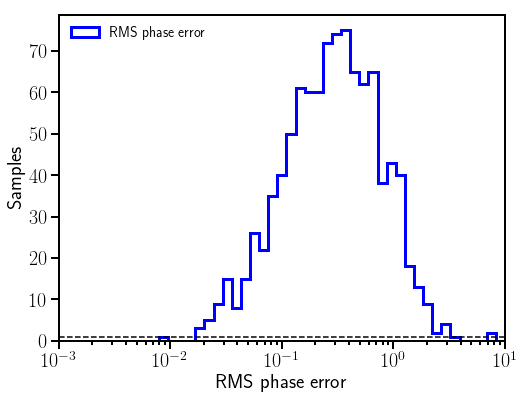

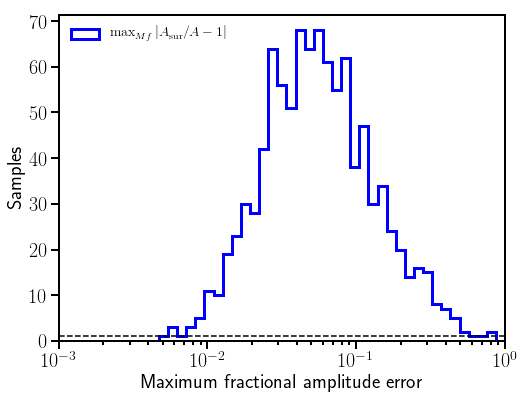

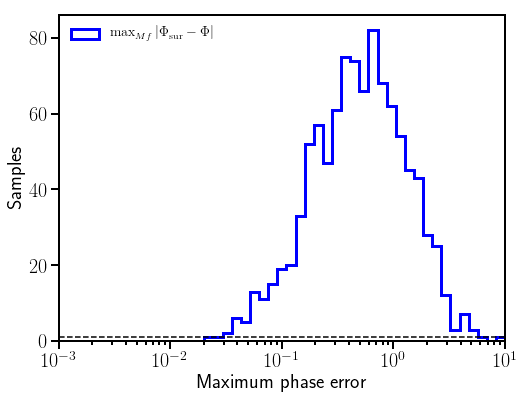

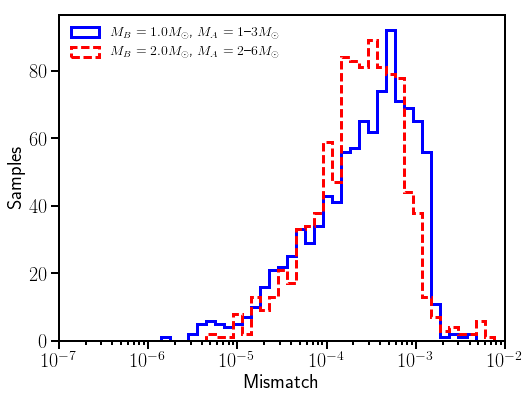

In [12]:
fig, ax2 = plt.subplots(figsize=(8, 6))
ax2.hist(params_errors[:, 5], bins=np.logspace(-3, 1, 50), histtype='step', 
          ls='-', lw=3, color='blue', alpha=1.0, label=r'RMS phase error')
ax2.axhline(1.0, c='k', ls='--')
ax2.set_xscale('log')
#ax2.set_yscale('log')
ax2.set_xlim([1.0e-3, 10.0])
#ax2.set_ylim([0.9, 1000])
ax2.set_xlabel('RMS phase error')
ax2.set_ylabel('Samples')
ax2.legend(loc='upper left', frameon=False)




fig, ax1 = plt.subplots(figsize=(8, 6))
ax1.hist(params_errors[:, 6], bins=np.logspace(-3, 0, 50), histtype='step', 
          ls='-', lw=3, color='blue', alpha=1.0, label=r'$\max_{Mf}|A_{\rm sur}/A-1|$')
ax1.axhline(1.0, c='k', ls='--')
ax1.set_xscale('log')
#ax1.set_yscale('log')
ax1.set_xlim([1.0e-3, 1.0])
#ax1.set_ylim([0.9, 1000])
ax1.set_xlabel('Maximum fractional amplitude error')
ax1.set_ylabel('Samples')
ax1.legend(loc='upper left', frameon=False)



fig, ax2 = plt.subplots(figsize=(8, 6))
ax2.hist(params_errors[:, 7], bins=np.logspace(-3, 1, 50), histtype='step', 
          ls='-', lw=3, color='blue', alpha=1.0, label=r'$\max_{Mf}|\Phi_{\rm sur}-\Phi|$')
ax2.axhline(1.0, c='k', ls='--')
ax2.set_xscale('log')
#ax2.set_yscale('log')
ax2.set_xlim([1.0e-3, 10.0])
#ax2.set_ylim([0.9, 1000])
ax2.set_xlabel('Maximum phase error')
ax2.set_ylabel('Samples')
ax2.legend(loc='upper left', frameon=False)



fig, ax = plt.subplots(figsize=(8, 6))

ax.hist(params_errors[:, 8], bins=np.logspace(-10, 0, 100), histtype='step', 
          ls='-', lw=3, color='blue', alpha=1.0, label=r'$M_B=1.0M_\odot$, $M_A=1$--$3M_\odot$')

ax.hist(params_errors[:, 9], bins=np.logspace(-10, 0, 100), histtype='step', 
          ls='--', lw=3, color='red', alpha=1.0, label=r'$M_B=2.0M_\odot$, $M_A=2$--$6M_\odot$')

#ax.axhline(1.0, c='k', ls='--')
ax.set_xscale('log')
#ax.set_yscale('log')
ax.set_xlim([1.0e-7, 1.0e-2])
#ax.set_ylim([0.9, 1000])
ax.set_xlabel('Mismatch')
ax.set_ylabel('Samples')
ax.legend(loc='upper left', frameon=False)
#fig.savefig('/home/bdlackey/public_html/ROM/mismatchhist.pdf', format='pdf', transparent=True, bbox_inches='tight')

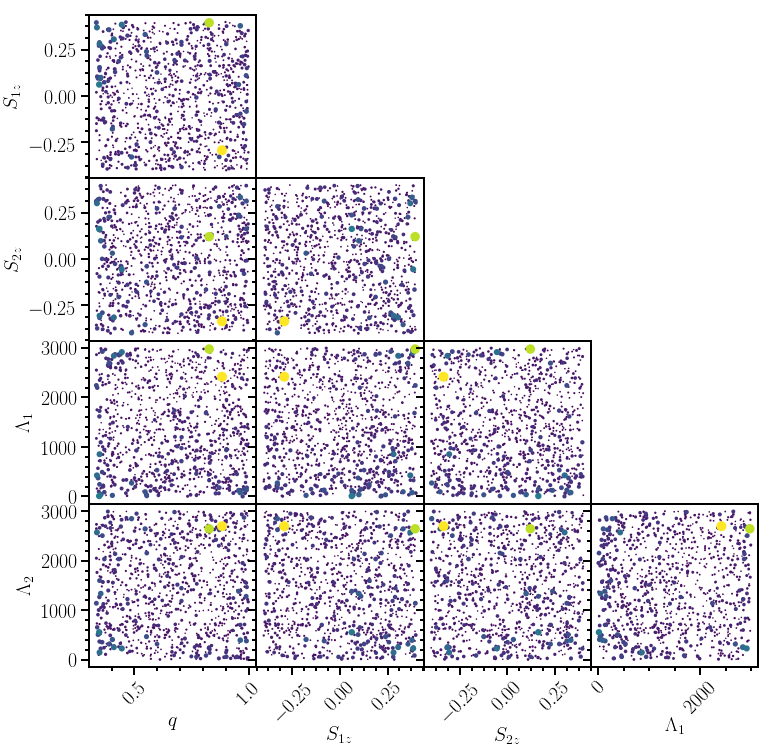

In [13]:
# RMS phase error
labels = [r'$q$', r'$S_{1z}$', r'$S_{2z}$', r'$\Lambda_1$', r'$\Lambda_2$']
params = params_errors[:, :5]
error = params_errors[:, 5]
fig, ax = diagnostics.error_2d_triangle_plot(params, error, labels, threshold=None, figsize=(10, 10))

# Compare errors to tidal phase contribution

246 862 974 212 562 463 191 279 933 698

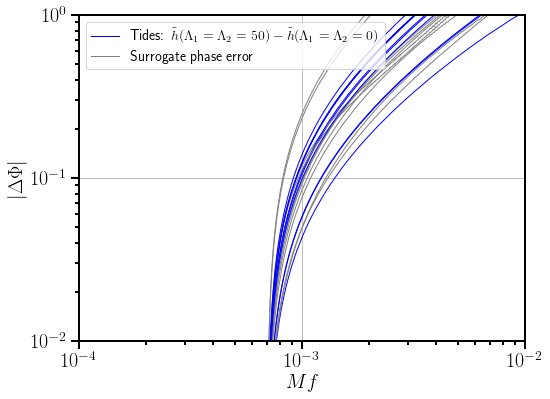

In [14]:
phase_error_indices_sorted_decrease = np.flip(np.argsort(params_errors[:, 7]), 0)

lam = 50.

fig, ax = plt.subplots(figsize=(8, 6))

j = 0
for i in phase_error_indices_sorted_decrease[:10]:
    print i, 
    hrand = testset_rand[i]
    params = testset_rand.get_waveform(i, data='parameters')
    hsur = sur.geometric_waveform(params)
    
    mfs = hsur.x
    error = np.abs(hsur.phase-hrand.phase)

    params_lam0 = np.array([params[0], params[1], params[2], 0., 0.])
    hsur_lam0 = sur.geometric_waveform(params_lam0)
    
    params_lam = np.array([params[0], params[1], params[2], lam, lam])
    hsur_lam = sur.geometric_waveform(params_lam)
    
    tidal_effect = np.abs(hsur_lam.phase-hsur_lam0.phase)
    
    if j==0:
        ax.plot(mfs, tidal_effect, ls='-', c='b', lw=1, 
                label=r'Tides: $\tilde h(\Lambda_1=\Lambda_2=50)-\tilde h(\Lambda_1=\Lambda_2=0)$')
    else:
        ax.plot(mfs, tidal_effect, ls='-', c='b', lw=1)
        
    if j==0:
        ax.plot(mfs, error, c='gray', lw=1, label='Surrogate phase error')
    else:
        ax.plot(mfs, error, c='gray', lw=1)
    
    j = 1

ax.set_ylabel(r'$|\Delta\Phi|$')
ax.set_xlabel(r'$Mf$')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim(0.0001, 0.01)
ax.set_ylim(1.0e-2, 1.)
ax.minorticks_on()
ax.grid()
ax.legend(loc='upper left')

246 [  8.829852e-01  -2.920735e-01  -3.351613e-01   2.418032e+03   2.695577e+03   8.101173e+00   3.489440e+00
   1.055813e+01   1.017825e-03   4.988891e-03]


(<matplotlib.figure.Figure at 0x11bc16fd0>,
 (<matplotlib.axes._subplots.AxesSubplot at 0x1186ece10>,
  <matplotlib.axes._subplots.AxesSubplot at 0x118a67850>))

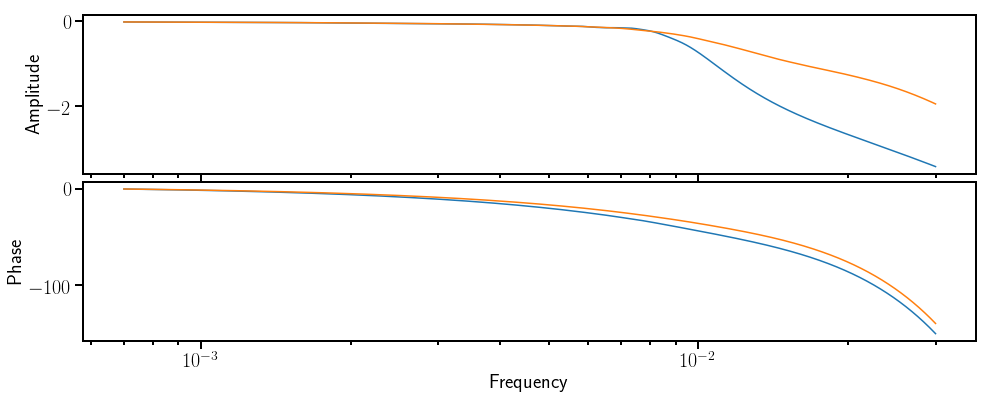

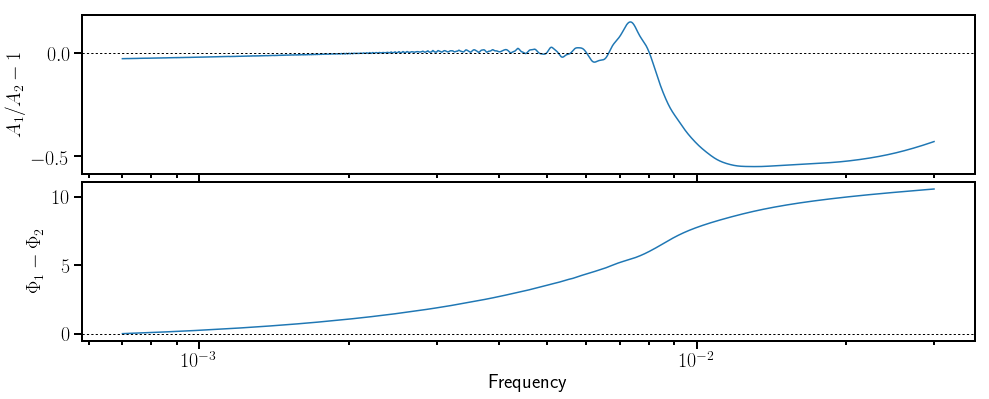

In [21]:
j = 0
max_error_i = phase_error_indices_sorted_decrease[j]
p = params_errors[max_error_i, :5]
hsur = sur.amp_phase_difference(p)
htest = dtestset_rand[max_error_i]

print max_error_i, params_errors[max_error_i]
wave.plot_waveforms_fd([htest, hsur])
wave.plot_waveform_difference_fd(hsur, htest)

In [18]:
rms_phase_error_i = np.flip(np.argsort(params_errors[:, 5]), 0)[:100]
max_phase_error_i = np.flip(np.argsort(params_errors[:, 7]), 0)[:100]
print rms_phase_error_i
print max_phase_error_i
# set is like list, but not. Learn about it.
common_i = list(set(rms_phase_error_i).intersection(max_phase_error_i))
print len(common_i)

[246 862 974 212 191 279 562 463 933  59 698 646 922 764  82 617 679 623  83 398 150   8 520 820  60 196 136
 484 666 221 768 357 757 889 864 855 733 724 847 823 490 395 392 938 209 871 566 853 468 694 706 342  58 276
 458 467 658 656  99 672 502 260 494 230 369 665 890 309 152 834 434 198 225 744 480 619  75   0 857  27 792
 881 407 303  78 479  70 147 287 404 488 295 460 114 765 504 377 423 983 370]
[246 862 974 212 562 463 191 279 933 698 922 617  59 679 764  82 398   8 623 150 733 646 484  83  60 196 820
 136 757 221 260 468 357 768 566 724 309  75 864 889 938 847 520 672 369 706 395 853 666 823 458 855 287 209
 490 502 276 504 658 342 744 225 871  58 644 295 834 192 392  99  78 230 792 983 303 665 479  27  31 656 198
 619 460 377 467 370 857 632 494 881 434 247 282 407 980 152 480  70 890  16]
92


# Create 3rd training set from largest phase error waveforms

In [55]:
params = params_errors[:, :5]
errors = params_errors[:, 5]
i_above_thresh = np.where(error>=0.1)[0]
#print i_above_thresh
new_params = params[i_above_thresh]
new_errors = errors[i_above_thresh]

print len(new_errors)
new_errors

71


array([ 0.113791,  0.103264,  0.106562,  0.132112,  0.113253,  0.126234,  0.195854,  0.183932,  0.100748,
        0.13384 ,  0.102298,  0.185687,  0.112622,  0.123425,  0.209935,  0.148916,  0.230871,  0.142793,
        0.103767,  0.132028,  0.103869,  0.106092,  0.112322,  0.129078,  0.149524,  0.146168,  0.118879,
        0.106566,  0.130993,  0.205706,  0.128059,  0.103116,  0.114881,  0.24639 ,  0.122257,  0.147665,
        0.116422,  0.199007,  0.118485,  0.202954,  0.100486,  0.10652 ,  0.152119,  0.245024,  0.146401,
        0.114251,  0.145621,  0.111732,  0.146045,  0.289228,  0.114056,  0.12231 ,  0.140472,  0.104167,
        0.108873,  0.10208 ,  0.117582,  0.121714,  0.231271,  0.188201,  0.124104,  0.199654,  0.158013,
        0.115634,  0.165306,  0.113555,  0.101807,  0.16005 ,  0.118384,  0.23284 ,  0.122283])

In [60]:
# new_h_list = [testset_rand[i] for i in i_above_thresh]
# new_dh_list = [dtestset_rand[i] for i in i_above_thresh]

# h_filename = '../data/flowp00015/h_training_set_rand.hdf5'
# dh_filename = '../data/flowp00015/dh_training_set_rand.hdf5'
# ws.waveform_set_from_list(h_filename, new_h_list, new_params)
# ws.waveform_set_from_list(dh_filename, new_dh_list, new_params)

In [61]:
# filename1 = '../data/flowp00015/h_training_set_lhd_uncsamp.hdf5'
# filename2 = '../data/flowp00015/h_training_set_rand.hdf5'
# filename_join = '../data/flowp00015/h_training_set_lhd_uncsamp_rand.hdf5'
# ws.join_waveform_sets(filename1, filename2, filename_join)

# filename1 = '../data/flowp00015/dh_training_set_lhd_uncsamp.hdf5'
# filename2 = '../data/flowp00015/dh_training_set_rand.hdf5'
# filename_join = '../data/flowp00015/dh_training_set_lhd_uncsamp_rand.hdf5'
# ws.join_waveform_sets(filename1, filename2, filename_join)